In [7]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import os
import random

# 0. Set Random Seed for Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Random seed set to {SEED} for reproducibility.")

# 1. Data Loading and Feature Integration (Using the complete engineered features)
# Load the engineered features and the train/test splits for the target variable.
try:
    # df_features = pd.read_csv("features.csv") # This file seems inconsistent in row count or purpose
    df_train = pd.read_csv("training_data.csv")
    df_test = pd.read_csv("test_data.csv")
except FileNotFoundError as e:
    print(f"Error: Required file not found. Make sure {e.filename} is in the directory.")
    raise

TARGET_COL = 'Target_Growth_Rate'
# 'growth_rate' in features.csv is the ratio form of the target, which we drop from X
# Assuming 'growth_rate' might also be in training_data/test_data and needs to be dropped.
FEATURES_TO_DROP = ['growth_rate', TARGET_COL]

# Extract features (X) and target (y) directly from the respective dataframes
X_train = df_train.drop(columns=FEATURES_TO_DROP, errors='ignore')
y_train = df_train[TARGET_COL]

X_test = df_test.drop(columns=FEATURES_TO_DROP, errors='ignore')
y_test = df_test[TARGET_COL]

print(f"--- Data Integration Summary ---")
# print(f"Engineered features loaded: {X_full.shape[1]}") # X_full is no longer used
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print("-" * 30)

# 2. Preprocessing Pipeline (KNN Imputation + Standard Scaling)

# KNN Imputation (Filling NaNs - critical step)
print("Starting KNN Imputation...")
imputer = KNNImputer(n_neighbors=5)
# Fit ONLY on X_train, then transform both
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standard Scaling (Normalization - critical for NN performance)
print("Starting Standard Scaling...")
scaler = StandardScaler()
# Fit ONLY on the imputed X_train, then transform both
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

input_dim = X_train_scaled.shape[1]
print(f"Preprocessing complete. NN Input Dimension: {input_dim}")

# 3. Build and Compile the Neural Network Model (MLP Regressor)
def build_nn_model(input_dim):
    # A robust Multi-Layer Perceptron (MLP) architecture
    model = Sequential([
        # Input/Hidden Layer 1
        Dense(128, activation='relu', input_shape=(input_dim,)),
        # Dropout to prevent overfitting (as per project requirement on error analysis)
        Dropout(0.1),
        # Hidden Layer 2
        Dense(64, activation='relu'),
        # Hidden Layer 3
        Dense(32, activation='relu'),
        # Output Layer: Single neuron for regression (linear activation)
        Dense(1, activation='linear')
    ])

    model.compile(
        optimizer='adam',
        loss='mse',      # Mean Squared Error (MSE)
        metrics=['mae']  # Mean Absolute Error (MAE) for project reporting
    )
    return model

nn_model = build_nn_model(input_dim)
print("\n--- Neural Network Architecture ---")
nn_model.summary()

# 4. Train the Model with Early Stopping
# Early Stopping: Stops training if validation loss doesn't improve for 15 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

print("\n--- Starting Neural Network Training ---")
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=200,             # Set high, but Early Stopping will control it
    batch_size=32,
    validation_split=0.2,   # Use 20% of training data for validation
    callbacks=[early_stop],
    verbose=1
)
# 5. Final Evaluation and Reporting
print("\n--- Evaluating NN Performance on Test Data ---")
loss, mae = nn_model.evaluate(X_test_scaled, y_test, verbose=0)

# Make predictions to calculate RMSE
y_pred = nn_model.predict(X_test_scaled, verbose=0).flatten()

# Calculate RMSE: Root Mean Squared Error (as per Objective model selection)
# The 'squared' argument was removed in scikit-learn 1.0. We calculate MSE and then take its square root.
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"NN Model Test MAE (Mean Absolute Error): {mae:.4f}")
print(f"NN Model Test RMSE (Root Mean Squared Error): {rmse:.4f}")

print("\n--- Comparison Metric ---")
print(f"NN Final Test RMSE: {rmse:.4f}")



Random seed set to 42 for reproducibility.
--- Data Integration Summary ---
Training features shape: (5684, 9)
Test features shape: (1422, 9)
------------------------------
Starting KNN Imputation...
Starting Standard Scaling...
Preprocessing complete. NN Input Dimension: 9

--- Neural Network Architecture ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Starting Neural Network Training ---
Epoch 1/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 936.4420 - mae: 18.0000 - val_loss: 424.9231 - val_mae: 10.7111
Epoch 2/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 488.2602 - mae: 10.3606 - val_loss: 401.9822 - val_mae: 10.2959
Epoch 3/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 456.8706 - mae: 9.8434 - val_loss: 392.6798 - val_mae: 10.0923
Epoch 4/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 441.5974 - mae: 9.7404 - val_loss: 388.2254 - val_mae: 10.0030
Epoch 5/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 435.6859 - mae: 9.5771 - val_loss: 382.3716 - val_mae: 9.8164
Epoch 6/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 428.1787 - mae: 9.4852 - val_loss: 379.2785 - val_mae: 9.7777
Epoch 7/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 421.9750 - mae: 9.3389 - val_loss: 376.0898 - val_mae: 9.6871
Epoch 8/200
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 417.7798 - mae: 9.3152 - val_l

In [10]:
y_train_pred = nn_model.predict(X_train_scaled).flatten()
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(train_rmse)

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
16.307489255349473


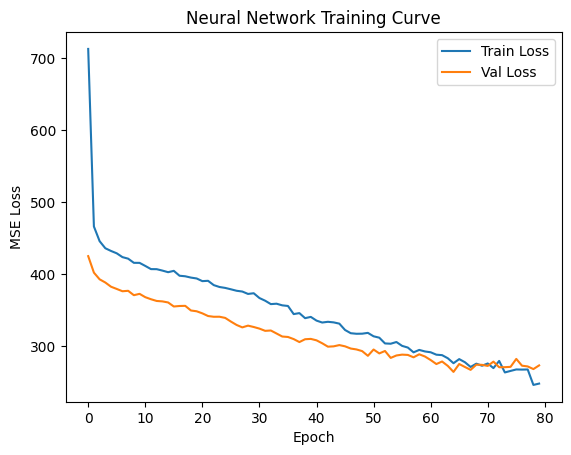

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training Curve')
plt.legend()
plt.show()


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


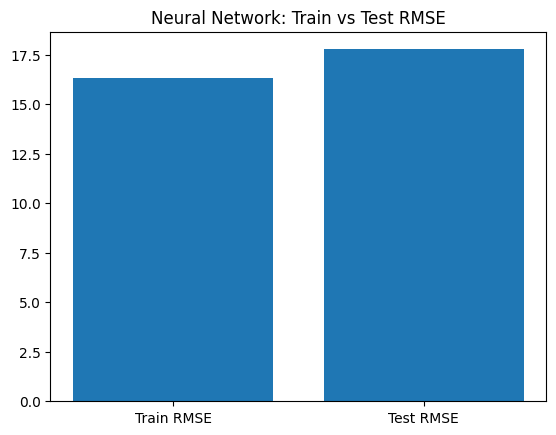

In [12]:
y_train_pred = nn_model.predict(X_train_scaled).flatten()
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

plt.bar(['Train RMSE', 'Test RMSE'], [train_rmse, rmse])
plt.title('Neural Network: Train vs Test RMSE')
plt.show()


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


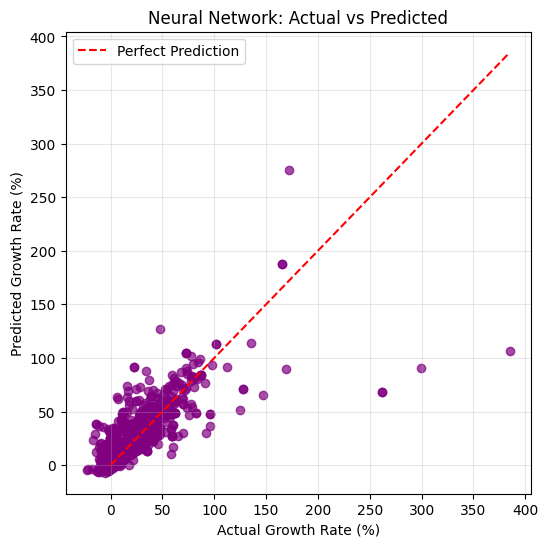

In [13]:
import matplotlib.pyplot as plt

# Make predictions
y_pred = nn_model.predict(X_test_scaled).flatten()

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, color='purple', alpha=0.7)

# Perfect prediction line
max_val = max(max(y_test), max(y_pred))
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')

plt.xlabel("Actual Growth Rate (%)")
plt.ylabel("Predicted Growth Rate (%)")
plt.title("Neural Network: Actual vs Predicted")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

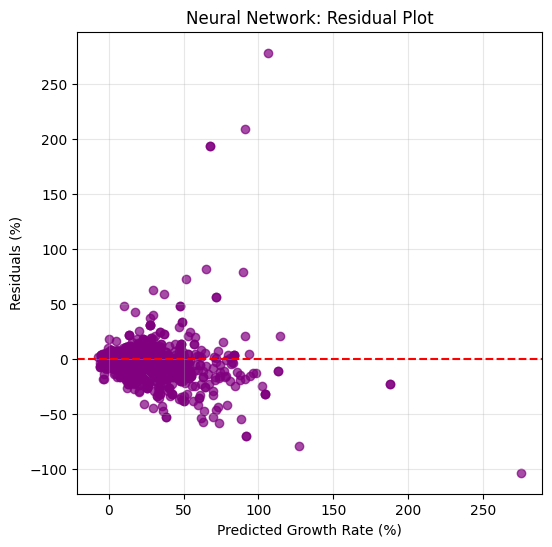

In [14]:
residuals = y_test - y_pred

plt.figure(figsize=(6, 6))
plt.scatter(y_pred, residuals, color='purple', alpha=0.7)

# Zero error line
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Predicted Growth Rate (%)")
plt.ylabel("Residuals (%)")
plt.title("Neural Network: Residual Plot")
plt.grid(alpha=0.3)
plt.show()
